In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

from IPython.core.pylabtools import figsize


In [2]:
training_data = pd.read_csv("../training/training_data_VT2026.csv")


training_data.head()

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,low_bike_demand


In [ ]:
pd.plotting.scatter_matrix(training_data.iloc[:, 1:18], figsize=(10,10))
plt.show()

kNN

In [26]:
np.random.seed(1)
trainI = np.random.choice(training_data.shape[0], size=300, replace=True)
trainIndex = training_data.index.isin(trainI)
train = training_data.iloc[trainIndex]
test = training_data.iloc[~trainIndex]

In [ ]:
input_variables = ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover', 'visibility']
X_train = train[['hour_of_day', 'day_of_week', 'summertime', 'temp', 'precip']]
Y_train = train['increase_stock']
X_test = test[['hour_of_day', 'day_of_week', 'summertime', 'temp', 'precip']]
Y_test = test['increase_stock']

In [6]:
model = skl_nb.KNeighborsClassifier(n_neighbors=13)
model.fit(X_train, Y_train)

print('model summary')
print(model)

model summary
KNeighborsClassifier(n_neighbors=13)


In [7]:
prediction = model.predict(X_test)
print('Confusion maatrix :\n')
print(pd.crosstab(prediction, Y_test), ':\n')
print(f"Accuracy: {np.mean(prediction == Y_test):.3f}")

Confusion maatrix :

increase_stock    high_bike_demand  low_bike_demand
row_0                                              
high_bike_demand               102               48
low_bike_demand                137             1043 :

Accuracy: 0.861


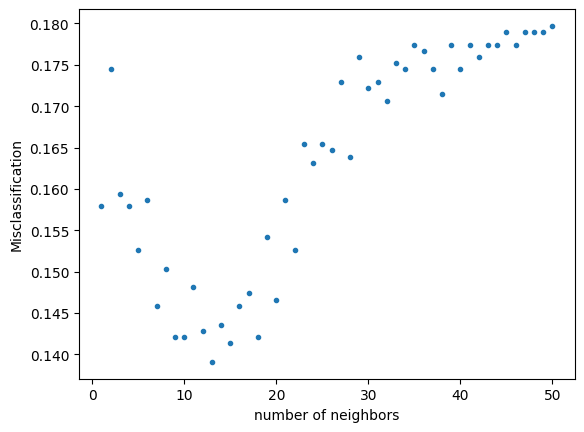

In [8]:
misclassification = []

for k in range(50):
    model = skl_nb.KNeighborsClassifier(n_neighbors=k+1)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    misclassification.append(np.mean(prediction != Y_test))

K = np.linspace(1, 50, 50)
plt.plot(K, misclassification, '.')
plt.ylabel('Misclassification')
plt.xlabel('number of neighbors')
plt.show()

*Cross validation*
rekommenderas för kNN

In [27]:
training_data[:10]

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,low_bike_demand
5,17,3,3,0,1,1,27.1,12.8,40.98,0.0,0,0.0,13.6,81.3,16.0,high_bike_demand
6,20,4,7,0,1,1,30.9,24.3,67.71,0.0,0,0.0,20.3,50.3,16.0,low_bike_demand
7,0,1,12,0,1,0,4.9,-1.7,62.46,0.0,0,0.0,21.5,100.0,16.0,low_bike_demand
8,18,0,11,0,1,0,16.6,13.8,83.56,0.0,0,0.0,18.1,88.9,16.0,low_bike_demand
9,7,5,1,0,0,0,-4.5,-12.2,55.14,0.0,0,0.0,12.4,24.4,16.0,low_bike_demand


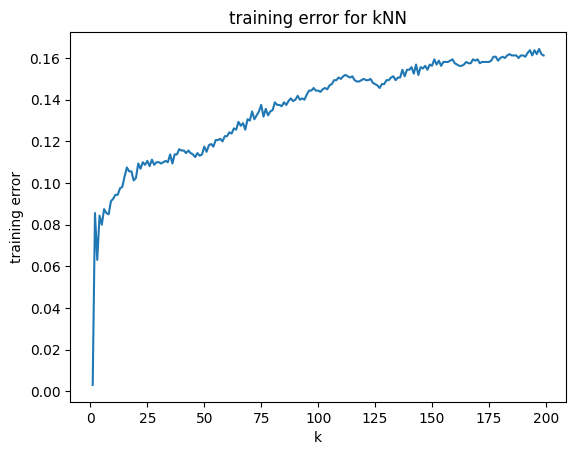

In [ ]:
#from excercise 6.1 a)
np.random.seed(1)

X = training_data[['hour_of_day', 'day_of_week', 'summertime', 'temp', 'precip']]
y = training_data['increase_stock']

misclassification = []

K = np.arange(1,200)
for k in K:
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X, y)
    prediction = model.predict(X)
    misclassification.append(np.mean(prediction != y))

plt.plot(K, misclassification)
plt.title('training error for kNN')
plt.xlabel('k')
plt.ylabel('training error')

plt.show()
    

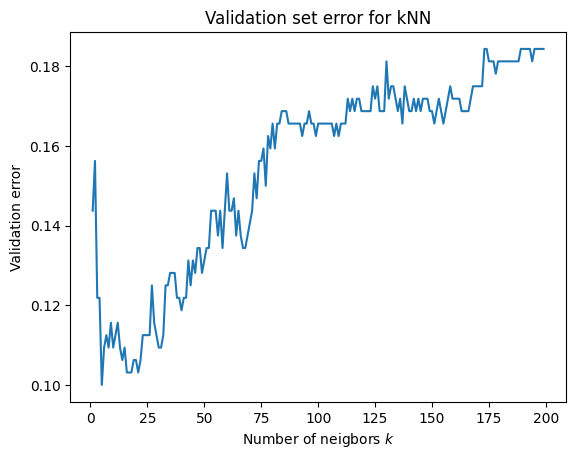

In [ ]:
#from excercise 6.1 b)
np.random.seed(1)

N = len(X)
M = np.ceil(0.8*N).astype(int)

idx = np.random.permutation(N)
X_train, X_val = X.iloc[idx[:M]], X.iloc[idx[M:]]
y_train, y_val = y.iloc[idx[:M]],  y.iloc[idx[M:]]

misclassification = []

K = np.arange(1,200)
for k in K:
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    misclassification.append(np.mean(prediction != y_val))

plt.plot(K, misclassification)
plt.title('Validation set error for kNN')
plt.xlabel('Number of neigbors $k$')
plt.ylabel('Validation error')
plt.show()

In [ ]:
n_runs = 10
K = np.arange(1,200)

misclassification = np.zeros((n_runs, len(k)))
for i in range(n_runs):
    X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size=0.2)